# Analyse descriptive

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  
#sys.path.append(str(PROJECT_ROOT))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


# Paths
DATA_VAL_PATH = "../data/processed/dataset_val.csv"
DATA_TRAIN_PATH = "../data/processed/dataset_train.csv"

# Load data
df_train = pd.read_csv(DATA_TRAIN_PATH)
df_val = pd.read_csv(DATA_VAL_PATH)


In [3]:
df_train["review_text"] = df_train["review_text"].fillna("").astype(str)
df_val["review_text"] = df_val["review_text"].fillna("").astype(str)

In [6]:
print("TRAIN :", len(df_train))
print("VAL   :", len(df_val))

TRAIN : 9959
VAL   : 5156


In [5]:
print("Nombre total d'avis :", len(df_val))
df_train.head()

Nombre total d'avis : 5156


,app_id,title,rating,review_text
0,570,Dota 2,3,"Gameplay is horrible, the game is dead"
1,570,Dota 2,9,These days I like the endless custom games tha...
2,570,Dota 2,3,The only people who play this game anymore are...
3,570,Dota 2,3,full of people that don't know what team play is
4,570,Dota 2,9,Just play til you understand.


In [ ]:
# Filter short reviews and create target variable
df_train = df_train[df_train["review_text"].str.len() >= 30].copy()
df_train["recommended"] = (df_train["rating"] == 9).astype(int)

df_val = df_val[df_val["review_text"].str.len() >= 30].copy()
df_val["recommended"] = (df_val["rating"] == 9).astype(int)

In [9]:
def label_distribution(df, name):
    return pd.DataFrame({
        "count": df["recommended"].value_counts(),
        "proportion": df["recommended"].value_counts(normalize=True)
    }).rename_axis("label").assign(dataset=name)

dist_train = label_distribution(df_train, "train")
dist_val = label_distribution(df_val, "val")

pd.concat([dist_train, dist_val])


,count,proportion,dataset
label,,,
1,6658,0.668541,train
0,3301,0.331459,train
1,4071,0.789566,val
0,1085,0.210434,val


Classes déséquilibrées avec davantage de reviews positives. Pas la même proportion entre le dataset d'entraînement et le dataset de validation

In [11]:
def add_length_features(df):
    df = df.copy()
    df["n_chars"] = df["review_text"].str.len()
    df["n_words"] = df["review_text"].str.split().str.len()
    return df

df_train = add_length_features(df_train)
df_val = add_length_features(df_val)


In [12]:
df_train["n_words"].describe(), df_val["n_words"].describe()


(count    9959.000000
 mean       57.896174
 std       121.936963
 min         1.000000
 25%        10.000000
 50%        20.000000
 75%        52.000000
 max      2816.000000
 Name: n_words, dtype: float64,
 count    5156.000000
 mean       70.545578
 std       132.109297
 min         1.000000
 25%        12.000000
 50%        27.000000
 75%        68.000000
 max      1471.000000
 Name: n_words, dtype: float64)

In [72]:
df_train["n_chars"].describe(), df_val["n_chars"].describe()

(count    9959.000000
 mean      318.487499
 std       668.183024
 min        30.000000
 25%        54.000000
 50%       109.000000
 75%       283.000000
 max      7999.000000
 Name: n_chars, dtype: float64,
 count    5156.000000
 mean      392.694337
 std       747.056991
 min        30.000000
 25%        65.000000
 50%       146.000000
 75%       378.000000
 max      8000.000000
 Name: n_chars, dtype: float64)

Des reviews en moyenne plus longues pour le dataset de validation, un écart type important dans tous les cas

In [ ]:
# Add lexical features
def add_lexical_features(df):
    df = df.copy()
    df["unique_words"] = df["review_text"].apply(lambda x: len(set(x.split())))
    df["lexical_diversity"] = df["unique_words"] / df["n_words"]
    return df

df_train = add_lexical_features(df_train)
df_val = add_lexical_features(df_val)


In [15]:
df_train["lexical_diversity"].mean(), df_val["lexical_diversity"].mean()


(np.float64(0.8916504844467307), np.float64(0.8732388279188246))

Similaire en complexité linguistique

In [18]:
# Mots les plus fréquents
def top_words(df, n=20):
    words = " ".join(df["review_text"]).lower().split()
    return Counter(words).most_common(n)

top_train = top_words(df_train)
top_val = top_words(df_val)

print("TRAIN:", top_train)
print("\nVAL:", top_val)


TRAIN: [('the', 24638), ('and', 14770), ('to', 14106), ('a', 12867), ('i', 10849), ('of', 9878), ('game', 9552), ('is', 9001), ('it', 7677), ('this', 7298), ('you', 7239), ('in', 6123), ('for', 5452), ('but', 4887), ('that', 4876), ('with', 4198), ('are', 3573), ('on', 3530), ('not', 3265), ('have', 3162)]

VAL: [('the', 17454), ('and', 10534), ('a', 9095), ('to', 8947), ('of', 7009), ('i', 6395), ('is', 6067), ('you', 5288), ('game', 5181), ('it', 4594), ('this', 4099), ('in', 3911), ('that', 3318), ('for', 3259), ('but', 3246), ('with', 3225), ('on', 2147), ('are', 2068), ('not', 1953), ('like', 1881)]


Similaire

In [19]:
# Structures concessives
df_train["has_but"] = df_train["review_text"].str.contains(r"\bbut\b", case=False)
df_val["has_but"] = df_val["review_text"].str.contains(r"\bbut\b", case=False)

df_train["has_but"].mean(), df_val["has_but"].mean()


(np.float64(0.29400542223114773), np.float64(0.34018619084561674))

Plus de structures concessives dans le validation. Problème pour la généralisation

In [53]:
# import pandas as pd
# import matplotlib.pyplot as plt

# Ajouter une colonne dataset
df_train_plot = df_train.copy()
df_train_plot["dataset"] = "Train"

df_val_plot = df_val.copy()
df_val_plot["dataset"] = "Test"

# Concaténation
df_plot = pd.concat([df_train_plot, df_val_plot], axis=0)



In [74]:

# Rename games (better for plots)
RENAME_GAMES = {
    "Grand Theft Auto: San Andreas – The Definitive Edition": "GTA SA",
    "Battlefield™ 2042": "BF 2042",
    "Counter-Strike 2": "CS2",
    "Cyberpunk 2077": "Cyberpunk",
    "Overwatch® 2": "Overwatch 2",
    "Darkest Dungeon® II": "Darkest Dungeon II",
    "Team Fortress 2": "TF2",
    "Deep Rock Galactic": "Deep Rock Galactic", 
}

df_train = df_train.copy()
df_val  = df_val.copy()

df_train["title"] = df_train["title"].replace(RENAME_GAMES)
df_val["title"]  = df_val["title"].replace(RENAME_GAMES)



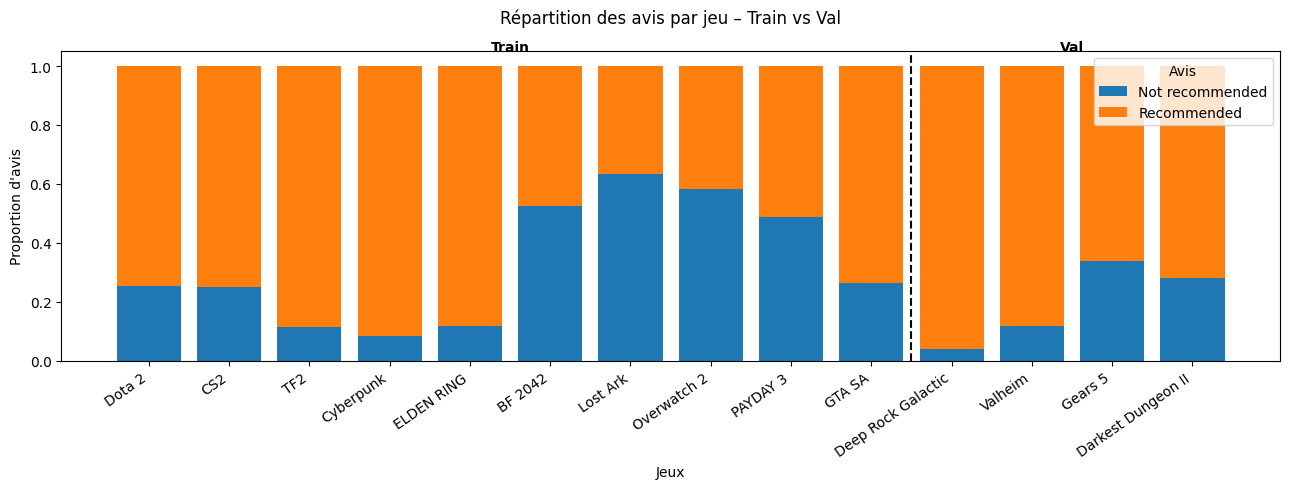

In [ ]:
# Games
games_train = df_train["title"].drop_duplicates().tolist()
games_test  = df_val["title"].drop_duplicates().tolist()

games = games_train + games_test
x = np.arange(len(games))

# Proportions
def proportions(df, games):
    not_rec, rec = [], []
    for g in games:
        sub = df[df["title"] == g]
        counts = sub["recommended"].value_counts(normalize=True)
        not_rec.append(counts.get(0, 0))
        rec.append(counts.get(1, 0))
    return not_rec, rec

not_rec_train, rec_train = proportions(df_train, games_train)
not_rec_test,  rec_test  = proportions(df_val,  games_test)

not_rec = not_rec_train + not_rec_test
rec     = rec_train     + rec_test

# Graphs
fig, ax = plt.subplots(figsize=(13, 5))

ax.bar(x, not_rec, label="Not recommended")
ax.bar(x, rec, bottom=not_rec, label="Recommended")

ax.set_xticks(x)
ax.set_xticklabels(games, rotation=35, ha="right")

ax.set_ylabel("Proportion d'avis")
ax.set_xlabel("Jeux")
ax.set_title("Répartition des avis par jeu – Train vs Val", pad = 20)

# Train / Test separation
sep = len(games_train)
ax.axvline(sep - 0.5, color="black", linestyle="--")

ax.text(sep / 2 - 0.5, 1.05, "Train", ha="center", fontweight="bold")
ax.text(sep + len(games_test) / 2 - 0.5, 1.05, "Val", ha="center", fontweight="bold")

ax.legend(title="Avis")

plt.tight_layout()
plt.show()
